In [1]:
import matplotlib
import matplotlib.pyplot as plt

import copy
import io
import numpy as np
import os
import six
import warnings

from collections import defaultdict
from IPython.display import clear_output
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from object_detection.builders import hyperparams_builder
from object_detection.builders import model_builder
from object_detection.core import standard_fields as fields
from object_detection.core.losses import Loss
from object_detection.predictors.heads import head
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import shape_utils
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils.visualization_utils import draw_bounding_box_on_image_array
from object_detection.utils.visualization_utils import STANDARD_COLORS

from KittiLabel import KittiLabel

%matplotlib inline

In [2]:
MODEL_PATH = "models_dwld/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8"
PIPELINE_CONFIG_PATH = MODEL_PATH + "/pipeline.config"
CHECKPOINT_PATH = MODEL_PATH + "/checkpoint/ckpt-0"

TRAIN_IMAGE_DIR = "train_size_1024_1024_padded_seed_20"
VAL_IMAGE_DIR = "val_size_1024_1024_padded_seed_20"
TEST_IMAGE_DIR = "test_size_1024_1024_padded_seed_20"

IMAGE_DIMS = (1024, 1024)

# Load model from config

In [3]:
num_classes = 2

In [4]:
tf.keras.backend.clear_session()

# get model config and build model 
# -see: https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG_PATH)
configs["model"].ssd.num_classes = num_classes
configs["model"].ssd.freeze_batchnorm = True

detection_model = model_builder.build(
    model_config=configs["model"], 
    is_training=True
)

# Set up Checkpoint restore
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
)

fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=fake_box_predictor
)

ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(CHECKPOINT_PATH).expect_partial()

# Run model through dummy image
image, shapes = detection_model.preprocess(tf.zeros([1, 1024, 1024, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

# Head

In [5]:
class NewBoxHead(tf.keras.layers.Layer):
    def __init__(self, mean_head, var_head):
        super(NewBoxHead, self).__init__()
        self.box_mean_head = mean_head
        self.box_var_head = var_head
        
    def call(self, inputs):
        mean_output = self.box_mean_head(inputs)
        var_output = self.box_var_head(inputs)
        output = tf.concat([mean_output, var_output], axis=1)
        return output

In [6]:
mean_head = copy.deepcopy(detection_model._box_predictor._box_prediction_head)
var_head = copy.deepcopy(detection_model._box_predictor._box_prediction_head)

new_box_head = NewBoxHead(mean_head, var_head)
detection_model._box_predictor._box_prediction_head = new_box_head

# Loss

In [7]:
class NLLLoss(Loss):
    def _compute_loss(self, prediction_tensor, target_tensor, weights):
        log_var = self.var_tensor
        var = tf.exp(log_var)
        epsilon = 0.001
        
        first_part = tf.math.log(tf.math.maximum(var, epsilon))
        second_part = ((1024 * (prediction_tensor - target_tensor)) ** 2) / tf.math.maximum(var, epsilon)
        
        return 0.5 * tf.reduce_mean(first_part + second_part)
    
    def _add_var_tensor(self, var_tensor):
        self.var_tensor = var_tensor
    
our_loss = NLLLoss()
detection_model._localization_loss = our_loss

# Save and Load checkpoint

In [8]:
def save_checkpoint(detection_model, checkpoint_path):
    checkpoint = tf.train.Checkpoint(model=detection_model)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=5)
    checkpoint.save(file_prefix=checkpoint_path)
    checkpoint.restore(manager.latest_checkpoint)
    print("Model saved")
    return checkpoint.model

def load_checkpoint(model, checkpoint_path):
    checkpoint = tf.train.Checkpoint(model=detection_model)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=5)
    checkpoint.restore(manager.latest_checkpoint)
    print("Model loaded")
    return checkpoint.model

#detection_model = load_checkpoint(detection_model, "path/ckptnumber/")

# Step function

In [9]:
tf.keras.backend.set_learning_phase(True)

C:\Users\Roko\anaconda3\envs\tensorflow\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [10]:
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead',
]

for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

In [11]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fn(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):
        shapes = tf.constant(batch_size * [[1024, 1024, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list
        )
        
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0
            )
            prediction_dict = model.predict(preprocessed_images, shapes)
            box_pred = prediction_dict["box_encodings"]
            
            # split output into mean and var output
            box_encodings = tf.concat(
                [
                    box_pred[0, 0:98304, :],
                    box_pred[0, 196608:221184, :],
                    box_pred[0, 245760:251904, :],
                    box_pred[0, 258048:259584, :],
                    box_pred[0, 261120:261504, :]
                ], axis=0
            )
            box_encodings = tf.expand_dims(box_encodings, axis=0)
            unc_encodings = tf.concat(
                [
                    box_pred[0, 98304:196608, :],
                    box_pred[0, 221184:245760, :],
                    box_pred[0, 251904:258048, :],
                    box_pred[0, 259584:261120, :],
                    box_pred[0, 261504:261888, :]
                ], axis=0
            )
            unc_encodings = tf.expand_dims(unc_encodings, axis=0)
            
            prediction_dict["box_encodings"] = box_encodings
            prediction_dict["uncertainty_encodings"] = unc_encodings
            
            model._localization_loss._add_var_tensor(unc_encodings)
            
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            
            # apply gradient clipping if neccessary
            #gradients = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1)) for grad in gradients]
            
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
            
            return_loss = {}
            return_loss["localization"] = losses_dict['Loss/localization_loss']
            return_loss["classification"] = losses_dict['Loss/classification_loss']
            
        return return_loss
    return train_step_fn


def get_model_loss_function(model):
    @tf.function
    def loss_function(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):
        shapes = tf.constant(batch_size * [[1024, 1024, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list
        )
        
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0
            )
            prediction_dict = model.predict(preprocessed_images, shapes)
            box_pred = prediction_dict["box_encodings"]
            
            box_encodings = tf.concat(
                [
                    box_pred[0, 0:98304, :],
                    box_pred[0, 196608:221184, :],
                    box_pred[0, 245760:251904, :],
                    box_pred[0, 258048:259584, :],
                    box_pred[0, 261120:261504, :]
                ], axis=0
            )
            box_encodings = tf.expand_dims(box_encodings, axis=0)
            unc_encodings = tf.concat(
                [
                    box_pred[0, 98304:196608, :],
                    box_pred[0, 221184:245760, :],
                    box_pred[0, 251904:258048, :],
                    box_pred[0, 259584:261120, :],
                    box_pred[0, 261504:261888, :]
                ], axis=0
            )
            unc_encodings = tf.expand_dims(unc_encodings, axis=0)
            
            prediction_dict["box_encodings"] = box_encodings
            prediction_dict["uncertainty_encodings"] = unc_encodings
            
            model._localization_loss._add_var_tensor(unc_encodings)
            losses_dict = model.loss(prediction_dict, shapes)
            
            total_loss = {}
            total_loss["localization"] = losses_dict['Loss/localization_loss']
            total_loss["classification"] = losses_dict['Loss/classification_loss']
        return total_loss
    return train_step_fn

In [12]:
learning_rate = 0.0001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune
)

loss_fn = get_model_loss_function(
    detection_model
)

# Setup variables for training

In [13]:
train_image_files = [
    f for f in os.listdir(TRAIN_IMAGE_DIR) if os.path.isfile(os.path.join(TRAIN_IMAGE_DIR, f)) and 
    os.path.join(TRAIN_IMAGE_DIR, f).endswith(".png")
]
val_image_files = [
    f for f in os.listdir(VAL_IMAGE_DIR) if os.path.isfile(os.path.join(VAL_IMAGE_DIR, f)) and 
    os.path.join(VAL_IMAGE_DIR, f).endswith(".png")
]
test_image_files = [
    f for f in os.listdir(TEST_IMAGE_DIR) if os.path.isfile(os.path.join(TEST_IMAGE_DIR, f)) and 
    os.path.join(TEST_IMAGE_DIR, f).endswith(".png")
]

In [14]:
num_epochs = 1
batch_size = 1
num_batches = int(np.ceil(len(train_image_files) / batch_size))

In [15]:
# one-hot encode classes

class_label_to_index = {
    "Car": 1,
    "Van": 1,
    "Truck": 1,
    "Pedestrian": 2,
    "Person_sitting": 2,
    "Cyclist": 2
}

ohe_class = {
    1: [1, 0],
    2: [0, 1]
}

category_index = {
    1: {
        "id": 1,
        "name": "vehicle"
    },
    2: {
        "id": 2,
        "name": "vru"
    }
}

val_losses = {
    "localization": [],
    "classification": []
}

train_losses = {
    "localization": [],
    "classification": []
}

In [16]:
def load_image_into_numpy_array(path):
    loaded_img = load_img(path)
    img_array = img_to_array(loaded_img)
    img_array_int8 = img_array.astype(np.uint8)
    return img_array_int8

def rescale_bounding_box(bbox):
    xmin, ymin, xmax, ymax = bbox
    return [ymin / IMAGE_DIMS[1], xmin / IMAGE_DIMS[0], ymax / IMAGE_DIMS[1], xmax / IMAGE_DIMS[0]]

In [18]:
warnings.filterwarnings('ignore')

for i in range(1, num_epochs + 1):
    
    current_batch = 0
    train_loss = {}
    train_loss["localization"] = 0
    train_loss["classification"] = 0
    
    while current_batch * batch_size < len(train_image_files):
        # get current batch files and labels
        current_batch_files = train_image_files[current_batch * batch_size:(current_batch + 1) * batch_size]
        current_batch_labels = [
            file_name.replace(".png", ".txt") for file_name in current_batch_files
        ]
        
        # initialize ground truth lists
        batch_classes_gt = []
        batch_boxes_gt = []
        
        # split labels into classes_gt and boxes_gt
        for current_batch_label in current_batch_labels:
            classes_gt = []
            boxes_gt = []
            with open(os.path.join(TRAIN_IMAGE_DIR, current_batch_label)) as label_file:
                for label_line in label_file:
                    # load kitti label
                    loaded_kitti_label = KittiLabel(label_line.strip())
                    
                    # append to ground truth if class of interest
                    if loaded_kitti_label.class_label in class_label_to_index.keys():
                        classes_gt.append(ohe_class[class_label_to_index[loaded_kitti_label.class_label]])
                        boxes_gt.append(rescale_bounding_box(loaded_kitti_label.bbox))
                        
            batch_classes_gt.append(tf.constant(classes_gt, dtype=tf.float32))
            batch_boxes_gt.append(tf.constant(boxes_gt, dtype=tf.float32))
        
        # get image tensors
        batch_image_tensors = []
        for current_batch_file in current_batch_files:
            image_np = load_image_into_numpy_array(os.path.join(TRAIN_IMAGE_DIR, current_batch_file))
            batch_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(image_np, dtype=tf.float32), axis=0))
            
        # execute train step
        train_loss_add = train_step_fn(
            batch_image_tensors,
            batch_boxes_gt,
            batch_classes_gt
        )
        # add train loss
        train_loss["localization"] += train_loss_add["localization"]
        train_loss["classification"] += train_loss_add["classification"]
        
        # print progress
        clear_output(wait=True)
        print(f"Done with epoch {i} batch {current_batch+1}/{num_batches}")
        current_batch += 1
        # for testing
        if current_batch == 200:
            break
    
    train_loss["localization"] /= len(train_image_files)
    train_loss["classification"] /= len(train_image_files)
    train_losses["localization"].append(train_loss["localization"])
    train_losses["classification"].append(train_loss["classification"])
    
    # save model
    #save_checkpoint(detection_model, f"save_folder/ckpt{i}/checkpoint")
    
    ########################################################################################################
    # comment out if validation is to be performed
    continue
    ########################################################################################################
    
    # validation loss
    val_loss = {}
    val_loss["localization"] = 0
    val_loss["classification"] = 0
    
    for val_image_file in val_image_files:
        current_files = [val_image_file]
        current_labels = [file_name.replace(".png", ".txt") for file_name in current_files]

        batch_classes_gt = []
        batch_boxes_gt = []

        for current_label in current_labels:
            classes_gt = []
            boxes_gt = []
            with open(os.path.join(VAL_IMAGE_DIR, current_label)) as label_file:
                for label_line in label_file:
                    # load kitti label
                    loaded_kitti_label = KittiLabel(label_line.strip())

                    # append to ground truth if class of interest
                    if loaded_kitti_label.class_label in class_label_to_index.keys():
                        classes_gt.append(ohe_class[class_label_to_index[loaded_kitti_label.class_label]])
                        boxes_gt.append(rescale_bounding_box(loaded_kitti_label.bbox))
            batch_classes_gt.append(tf.constant(classes_gt, dtype=tf.float32))
            batch_boxes_gt.append(tf.constant(boxes_gt, dtype=tf.float32))

        # get image tensors
        batch_image_tensors = []
        for current_file in current_files:
            image_np = load_image_into_numpy_array(os.path.join(VAL_IMAGE_DIR, current_file))
            batch_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(image_np, dtype=tf.float32), axis=0))

        # calculate loss
        val_loss_add = loss_fn(
            batch_image_tensors,
            batch_boxes_gt,
            batch_classes_gt
        ) 
        val_loss["localization"] += val_loss_add["localization"]
        val_loss["classification"] += val_loss_add["classification"]
    
    val_loss["localization"] /= len(val_image_files)
    val_loss["classification"] /= len(val_image_files)
    val_losses["localization"].append(val_loss["localization"])
    val_losses["classification"].append(val_loss["classification"])

Done with epoch 1 batch 200/5236


# Edit TF_API inference functions

In [19]:
def postprocess_v2(self, prediction_dict, true_image_shapes, unc_encodings):
    with tf.name_scope('Postprocessor'):
        preprocessed_images = prediction_dict['preprocessed_inputs']
        box_encodings = prediction_dict['box_encodings']
        box_encodings = tf.identity(box_encodings, 'raw_box_encodings')
        class_predictions_with_background = (prediction_dict['class_predictions_with_background'])
        detection_boxes, detection_keypoints = self._batch_decode(box_encodings, prediction_dict['anchors'])
        detection_boxes = tf.identity(detection_boxes, 'raw_box_locations')
        detection_boxes = tf.expand_dims(detection_boxes, axis=2)

        detection_scores_with_background = self._score_conversion_fn(class_predictions_with_background)
        detection_scores = tf.identity(detection_scores_with_background, 'raw_box_scores')
        if self._add_background_class or self._explicit_background_class:
            detection_scores = tf.slice(detection_scores, [0, 0, 1], [-1, -1, -1])
        additional_fields = None

        batch_size = (shape_utils.combined_static_and_dynamic_shape(preprocessed_images)[0])

        if 'feature_maps' in prediction_dict:
            feature_map_list = []
            for feature_map in prediction_dict['feature_maps']:
                feature_map_list.append(tf.reshape(feature_map, [batch_size, -1]))
            box_features = tf.concat(feature_map_list, 1)
            box_features = tf.identity(box_features, 'raw_box_features')
        additional_fields = {
            'multiclass_scores': detection_scores_with_background,
            'unc_encodings': unc_encodings
        }
        if self._anchors is not None:
            num_boxes = (self._anchors.num_boxes_static() or self._anchors.num_boxes())
            anchor_indices = tf.range(num_boxes)
            batch_anchor_indices = tf.tile(
            tf.expand_dims(anchor_indices, 0), [batch_size, 1])
            # All additional fields need to be float.
            additional_fields.update({
                'anchor_indices': tf.cast(batch_anchor_indices, tf.float32),
            })
        if detection_keypoints is not None:
            detection_keypoints = tf.identity(detection_keypoints, 'raw_keypoint_locations')
            additional_fields[fields.BoxListFields.keypoints] = detection_keypoints

        (nmsed_boxes, nmsed_scores, nmsed_classes, nmsed_masks, 
         nmsed_additional_fields, num_detections) = self._non_max_suppression_fn(
            detection_boxes,
            detection_scores,
            clip_window=self._compute_clip_window(
                preprocessed_images, true_image_shapes),
            additional_fields=additional_fields,
            masks=prediction_dict.get('mask_predictions')
        )
        detection_dict = {
            fields.DetectionResultFields.detection_boxes: nmsed_boxes,
            fields.DetectionResultFields.detection_scores: nmsed_scores,
            fields.DetectionResultFields.detection_classes: nmsed_classes,
            fields.DetectionResultFields.num_detections: tf.cast(num_detections, dtype=tf.float32),
            fields.DetectionResultFields.raw_detection_boxes: tf.squeeze(detection_boxes, axis=2),
            fields.DetectionResultFields.raw_detection_scores: detection_scores_with_background,
            "uncertainty_boxes": nmsed_additional_fields["unc_encodings"]
        }
        if (nmsed_additional_fields is not None and fields.InputDataFields.multiclass_scores in nmsed_additional_fields):
            detection_dict[fields.DetectionResultFields.detection_multiclass_scores] = (
                nmsed_additional_fields[fields.InputDataFields.multiclass_scores]
            )
        if (nmsed_additional_fields is not None and 'anchor_indices' in nmsed_additional_fields):
            detection_dict.update({
                fields.DetectionResultFields.detection_anchor_indices: 
                tf.cast(nmsed_additional_fields['anchor_indices'], tf.int32),
            })
        if (nmsed_additional_fields is not None and fields.BoxListFields.keypoints in nmsed_additional_fields):
            detection_dict[fields.DetectionResultFields.detection_keypoints] = (nmsed_additional_fields[fields.BoxListFields.keypoints])
        if nmsed_masks is not None:
            detection_dict[fields.DetectionResultFields.detection_masks] = nmsed_masks
        return detection_dict

In [32]:
def custom_visualization_with_uncertainty(image,
                                          boxes,
                                          classes,
                                          scores,
                                          category_index,
                                          uncertainty_boxes,
                                          instance_masks=None,
                                          instance_boundaries=None,
                                          keypoints=None,
                                          keypoint_scores=None,
                                          keypoint_edges=None,
                                          track_ids=None,
                                          use_normalized_coordinates=False,
                                          max_boxes_to_draw=None,
                                          min_score_thresh=.5,
                                          agnostic_mode=False,
                                          line_thickness=2,
                                          mask_alpha=.4,
                                          groundtruth_box_visualization_color='black',
                                          skip_boxes=False,
                                          skip_scores=False,
                                          skip_labels=False,
                                          skip_track_ids=False):
    
    box_to_display_str_map = defaultdict(list)
    box_to_color_map = defaultdict(str)
    box_to_instance_masks_map = {}
    box_to_instance_boundaries_map = {}
    box_to_keypoints_map = defaultdict(list)
    box_to_keypoint_scores_map = defaultdict(list)
    box_to_track_ids_map = {}
    if not max_boxes_to_draw:
        max_boxes_to_draw = boxes.shape[0]
    for i in range(boxes.shape[0]):
        if max_boxes_to_draw == len(box_to_color_map):
            break
        if scores is None or scores[i] > min_score_thresh:
            box = tuple(boxes[i].tolist()) + tuple(uncertainty_boxes[i].tolist())
            if instance_masks is not None:
                box_to_instance_masks_map[box] = instance_masks[i]
            if instance_boundaries is not None:
                box_to_instance_boundaries_map[box] = instance_boundaries[i]
            if keypoints is not None:
                box_to_keypoints_map[box].extend(keypoints[i])
            if keypoint_scores is not None:
                box_to_keypoint_scores_map[box].extend(keypoint_scores[i])
            if track_ids is not None:
                box_to_track_ids_map[box] = track_ids[i]
            if scores is None:
                box_to_color_map[box] = groundtruth_box_visualization_color
            else:
                display_str = ''
                if not skip_labels:
                    if not agnostic_mode:
                        if classes[i] in six.viewkeys(category_index):
                            class_name = category_index[classes[i]]['name']
                        else:
                            class_name = 'N/A'
                        display_str = str(class_name)
                if not skip_scores:
                    if not display_str:
                        display_str = '{}%'.format(round(100*scores[i]))
                    else:
                        display_str = '{}: {}%'.format(display_str, round(100*scores[i]))
                if not skip_track_ids and track_ids is not None:
                    if not display_str:
                        display_str = 'ID {}'.format(track_ids[i])
                    else:
                        display_str = '{}: ID {}'.format(display_str, track_ids[i])
                box_to_display_str_map[box].append(display_str)
                if agnostic_mode:
                    box_to_color_map[box] = 'DarkOrange'
                elif track_ids is not None:
                    prime_multipler = _get_multiplier_for_color_randomness()
                    box_to_color_map[box] = STANDARD_COLORS[(prime_multipler * track_ids[i]) % len(STANDARD_COLORS)]
                else:
                    box_to_color_map[box] = STANDARD_COLORS[classes[i] % len(STANDARD_COLORS)]
                    
    # Draw all boxes onto image.
    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax, ymin_unc, xmin_unc, ymax_unc, xmax_unc = box
        if instance_masks is not None:
            draw_mask_on_image_array(
                image,
                box_to_instance_masks_map[box],
                color=color,
                alpha=mask_alpha
            )
        if instance_boundaries is not None:
            draw_mask_on_image_array(
                image,
                box_to_instance_boundaries_map[box],
                color='red',
                alpha=1.0
            )
            
        ############################################ Object visualization
        draw_bounding_box_on_image_array(
            image,
            ymin,
            xmin,
            ymax,
            xmax,
            color=color,
            thickness=0 if skip_boxes else line_thickness,
            display_str_list=box_to_display_str_map[box],#()
            use_normalized_coordinates=use_normalized_coordinates
        )
        draw_bounding_box_on_image_array(
            image,
            ymin - (ymin_unc),# / 2,
            xmin - (xmin_unc),# / 2,
            ymax + (ymax_unc),# / 2,
            xmax + (xmax_unc),# / 2,
            color=color,
            thickness=1,
            display_str_list=(),
            use_normalized_coordinates=use_normalized_coordinates
        )
        draw_bounding_box_on_image_array(
            image,
            ymin + (ymin_unc),# / 2,
            xmin + (xmin_unc),# / 2,
            ymax - (ymax_unc),# / 2,
            xmax - (xmax_unc),# / 2,
            color=color,
            thickness=1,
            display_str_list=(),
            use_normalized_coordinates=use_normalized_coordinates
        )
        #############################################
        
        if keypoints is not None:
            keypoint_scores_for_box = None
            if box_to_keypoint_scores_map:
                keypoint_scores_for_box = box_to_keypoint_scores_map[box]
            draw_keypoints_on_image_array(
                image,
                box_to_keypoints_map[box],
                keypoint_scores_for_box,
                min_score_thresh=min_score_thresh,
                color=color,
                radius=line_thickness / 2,
                use_normalized_coordinates=use_normalized_coordinates,
                keypoint_edges=keypoint_edges,
                keypoint_edge_color=color,
                keypoint_edge_width=line_thickness // 2
            )

    return image

# Run inference

In [33]:
detection_model.postprocess_v2 = postprocess_v2.__get__(detection_model)

In [34]:
example_test_image = load_image_into_numpy_array("test_size_1024_1024_padded_seed_20/000201.png")

examples = []
examples.append(np.expand_dims(example_test_image, axis=0))

In [35]:
@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    
    box_pred = prediction_dict["box_encodings"]
    box_encodings = tf.concat(
        [
            box_pred[0, 0:98304, :],
            box_pred[0, 196608:221184, :],
            box_pred[0, 245760:251904, :],
            box_pred[0, 258048:259584, :],
            box_pred[0, 261120:261504, :]
        ], axis=0
    )
    unc_encodings = tf.concat(
        [
            box_pred[0, 98304:196608, :],
            box_pred[0, 221184:245760, :],
            box_pred[0, 251904:258048, :],
            box_pred[0, 259584:261120, :],
            box_pred[0, 261504:261888, :]
        ], axis=0
    )
    box_encodings = tf.expand_dims(box_encodings, axis=0)
    unc_encodings = tf.expand_dims(unc_encodings, axis=0)
    
    prediction_dict["box_encodings"] = box_encodings
    prediction_dict["unc_encodings"] = unc_encodings
    
    #return detection_model.postprocess(prediction_dict, shapes), unc_encodings
    return detection_model.postprocess_v2(prediction_dict, shapes, unc_encodings)

In [36]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    uncertainty_boxes,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    min_score_thresh=0.5):
    image_np_with_annotations = image_np.copy()
    #viz_utils.visualize_boxes_and_labels_on_image_array
    custom_visualization_with_uncertainty(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        uncertainty_boxes=uncertainty_boxes,
        use_normalized_coordinates=True,
        min_score_thresh=min_score_thresh
    )
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

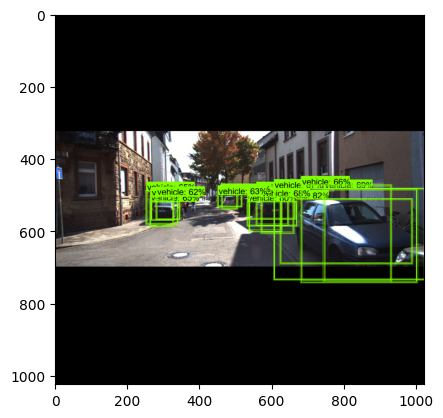

In [37]:
exa = tf.convert_to_tensor(examples[0], dtype=tf.float32)
detections = detect(exa)
    
detections["uncertainty_boxes"] = tf.exp(detections["uncertainty_boxes"])
detections["uncertainty_boxes"] = detections["uncertainty_boxes"] ** 0.5
detections["uncertainty_boxes"] = detections["uncertainty_boxes"] / 1024

plot_detections(
    examples[0][0],
    detections["detection_boxes"][0].numpy(),
    detections["detection_classes"][0].numpy().astype(np.uint32) + 1,
    detections["detection_scores"][0].numpy(),
    detections["uncertainty_boxes"][0].numpy(),
    category_index,
    figsize=(10, 10),
    #image_name="example.jpg",
    min_score_thresh=0.60
)